# Small Cardamom Price Forecasting

This notebook builds a time-series forecasting model to predict the **Average Price (Rs./Kg)** of small cardamom based on historical auction data.

**Data:** Small Cardamom Auction Prices (Nov 2014 - Feb 2026)  
**Target:** Avg. Price (Rs./Kg)  
**Approach:** Feature engineering + XGBoost / Random Forest / ARIMA comparison

## 1. Data Loading & Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 100

# Load data - the .xls file is HTML-formatted
df = pd.read_html('Small Cardamom Auction Prices.xls', header=0)[0]
# The first row may be a duplicate header — drop rows where Date column matches header text
df = df[df.iloc[:, 0] != 'Date of Auction'].reset_index(drop=True)
print(f'Shape: {df.shape}')
df.head()

Shape: (5440, 7)


,Date of Auction,Auctioneer,No.of Lots,Total Qty Arrived (Kgs),Qty Sold (Kgs),MaxPrice (Rs./Kg),Avg.Price (Rs./Kg)
0,2026-02-06,SOUTH INDIAN CARDAMOM ONLINE AUCTION PRIVATE L...,217,51761.9,50329.5,2905.0,2504.66
1,2026-02-05,SPECIALITY INDIAN FOOD PARKS EXPORTS PRIVATE L...,259,73143.8,72884.7,3332.0,2488.81
2,2026-02-05,THE CARDAMOM PLANTERS MARKETING CO-OPERATIVE S...,247,73136.9,72801.1,2908.0,2479.02
3,2026-02-04,IDUKKI MAHILA CARDAMOM PRODUCER COMPANY LIMITED,255,64303.2,63392.7,3285.0,2493.29
4,2026-02-04,SUGANDHAGIRI SPICES PROMOTERS&TRADERS Pvt Ltd,297,81171.9,80122.5,2992.0,2465.05


In [2]:
# Rename columns for convenience
df.columns = ['Date', 'Auctioneer', 'Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)

for col in ['Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows that couldn't be parsed
df = df.dropna(subset=['Date']).reset_index(drop=True)

print(f'Date range: {df["Date"].min()} to {df["Date"].max()}')
print(f'Missing values:\n{df.isnull().sum()}')
print(f'\nBasic stats:')
df.describe()

Date range: 2014-11-07 00:00:00 to 2026-02-06 00:00:00
Missing values:
Date              0
Auctioneer        0
Lots              0
Qty_Arrived_Kg    0
Qty_Sold_Kg       0
MaxPrice          0
AvgPrice          0
dtype: int64

Basic stats:


,Date,Lots,Qty_Arrived_Kg,Qty_Sold_Kg,MaxPrice,AvgPrice
count,5440,5440.000000,5440.000000,5440.000000,5440.000000,5440.000000
mean,2020-11-10 00:00:31.764705792,224.980331,52117.283704,49898.469164,1965.315625,1526.960608
min,2014-11-07 00:00:00,11.000000,2296.900000,0.000000,0.000000,0.000000
25%,2017-10-29 12:00:00,164.000000,31417.775000,29846.925000,1274.750000,922.102500
50%,2021-02-01 12:00:00,218.000000,50437.600000,47817.250000,1662.000000,1259.515000
75%,2023-09-23 12:00:00,271.000000,68377.550000,65676.775000,2716.250000,2214.715000
max,2026-02-06 00:00:00,790.000000,210080.000000,511177.000000,7000.000000,4733.190000
std,NaN,93.248315,26791.321509,26868.782217,874.891582,797.992710


In [3]:
# Multiple auctions happen on the same date (different auctioneers)
# Aggregate to daily level: weighted average price by quantity sold
daily = df.groupby('Date').agg(
    Total_Lots=('Lots', 'sum'),
    Total_Arrived=('Qty_Arrived_Kg', 'sum'),
    Total_Sold=('Qty_Sold_Kg', 'sum'),
    MaxPrice=('MaxPrice', 'max'),
    # Weighted average price
    AvgPrice_WAM=('AvgPrice', lambda x: np.average(x, weights=df.loc[x.index, 'Qty_Sold_Kg'].clip(lower=1))),
    AvgPrice_Simple=('AvgPrice', 'mean'),
    Num_Auctions=('Auctioneer', 'nunique')
).reset_index()

# Use weighted average as our target
daily['AvgPrice'] = daily['AvgPrice_WAM']
daily = daily.sort_values('Date').reset_index(drop=True)

# Remove rows with zero/missing prices
daily = daily[daily['AvgPrice'] > 0].reset_index(drop=True)

print(f'Daily records: {len(daily)}')
print(f'Date range: {daily["Date"].min().date()} to {daily["Date"].max().date()}')
daily.head(10)

Daily records: 3028
Date range: 2014-11-07 to 2026-02-06


,Date,Total_Lots,Total_Arrived,Total_Sold,MaxPrice,AvgPrice_WAM,AvgPrice_Simple,Num_Auctions,AvgPrice
0,2014-11-07,477,109975.0,109076.0,958.0,765.730000,765.730,1,765.730000
1,2015-01-14,350,76699.0,76699.0,1130.0,861.930000,861.930,1,861.930000
2,2015-05-01,203,31117.0,30755.0,928.0,706.624575,699.995,2,706.624575
3,2015-05-02,488,82457.0,75138.0,990.0,681.104290,675.715,2,681.104290
4,2015-05-04,242,39221.0,38109.0,964.0,673.615962,672.585,2,673.615962
5,2015-05-05,498,98201.0,97274.0,952.0,688.410135,684.880,2,688.410135
6,2015-05-06,334,60247.0,58476.0,947.0,683.064064,683.135,2,683.064064
7,2015-05-07,464,102759.0,101924.0,972.0,671.524961,671.540,2,671.524961
8,2015-05-08,326,52304.0,51863.0,925.0,673.211788,672.580,2,673.211788
9,2015-05-09,484,82661.0,82082.0,915.0,661.621337,658.025,2,661.621337


## 2. Exploratory Data Analysis

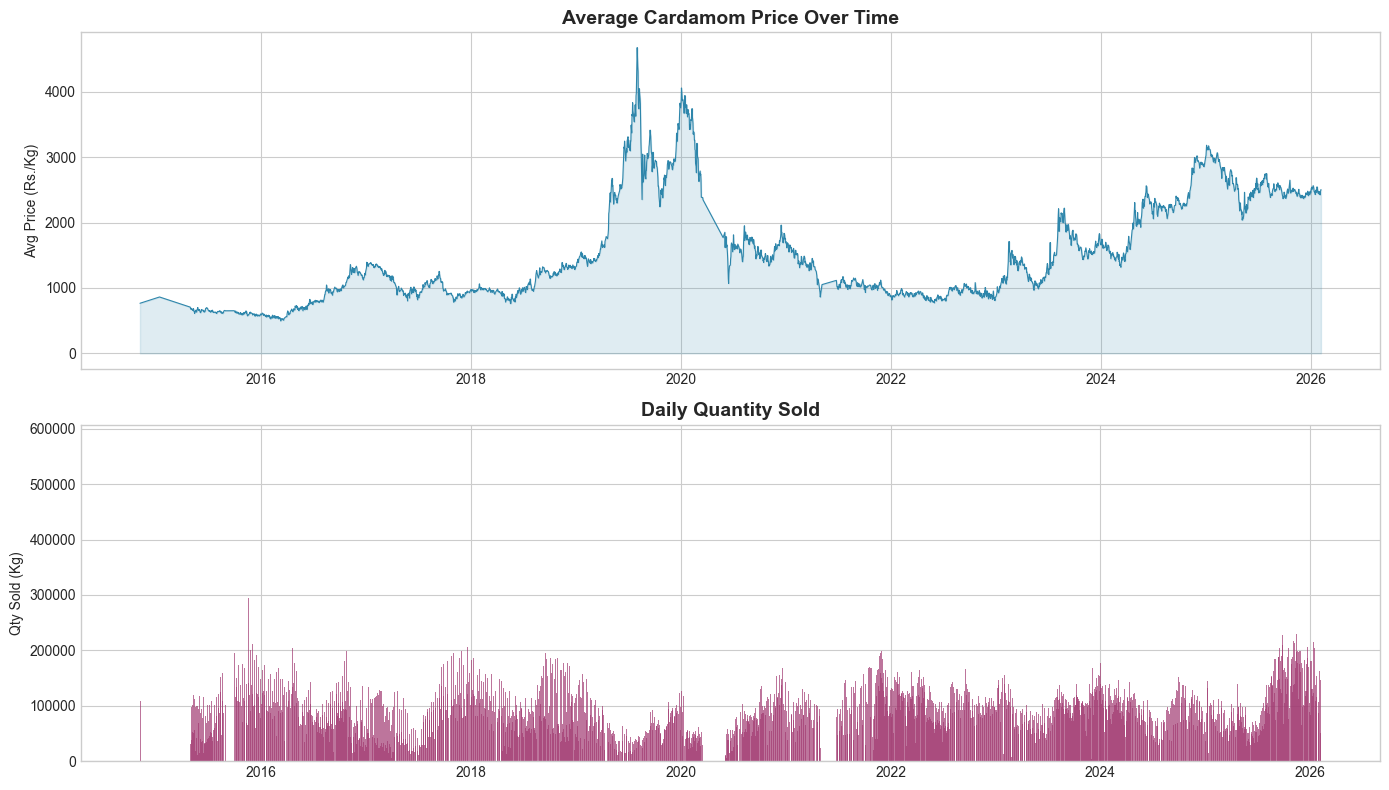

In [4]:
# Price over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(daily['Date'], daily['AvgPrice'], linewidth=0.8, color='#2E86AB')
axes[0].set_title('Average Cardamom Price Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Avg Price (Rs./Kg)')
axes[0].fill_between(daily['Date'], daily['AvgPrice'], alpha=0.15, color='#2E86AB')

axes[1].bar(daily['Date'], daily['Total_Sold'], width=2, color='#A23B72', alpha=0.7)
axes[1].set_title('Daily Quantity Sold', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Qty Sold (Kg)')

plt.tight_layout()
plt.show()

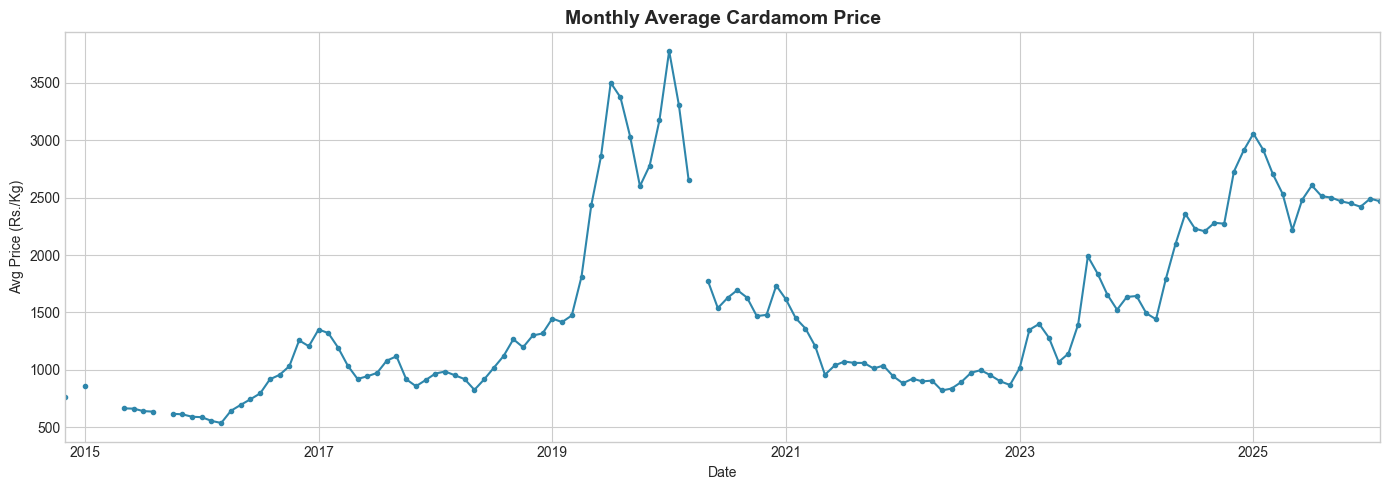

In [5]:
# Monthly average price trend
monthly = daily.set_index('Date').resample('M')['AvgPrice'].mean()

fig, ax = plt.subplots(figsize=(14, 5))
monthly.plot(ax=ax, marker='o', markersize=3, linewidth=1.5, color='#2E86AB')
ax.set_title('Monthly Average Cardamom Price', fontsize=14, fontweight='bold')
ax.set_ylabel('Avg Price (Rs./Kg)')
plt.tight_layout()
plt.show()

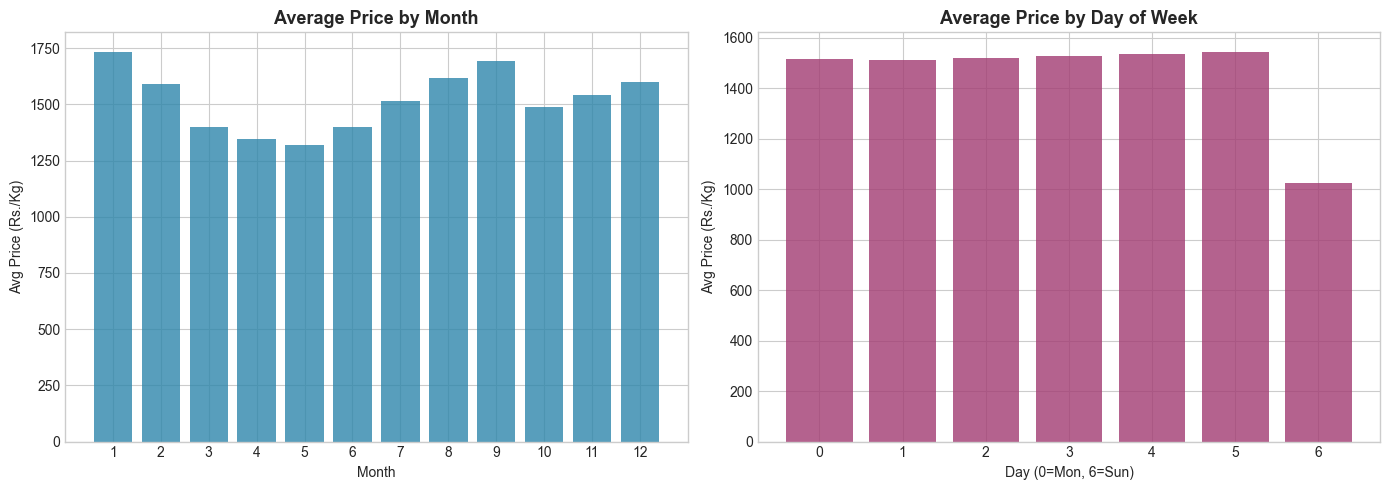

In [6]:
# Seasonality: average price by month
daily['Month'] = daily['Date'].dt.month
daily['Year'] = daily['Date'].dt.year
daily['DayOfWeek'] = daily['Date'].dt.dayofweek

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

monthly_season = daily.groupby('Month')['AvgPrice'].mean()
axes[0].bar(monthly_season.index, monthly_season.values, color='#2E86AB', alpha=0.8)
axes[0].set_title('Average Price by Month', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Avg Price (Rs./Kg)')
axes[0].set_xticks(range(1, 13))

dow_season = daily.groupby('DayOfWeek')['AvgPrice'].mean()
axes[1].bar(dow_season.index, dow_season.values, color='#A23B72', alpha=0.8)
axes[1].set_title('Average Price by Day of Week', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Day (0=Mon, 6=Sun)')
axes[1].set_ylabel('Avg Price (Rs./Kg)')

plt.tight_layout()
plt.show()

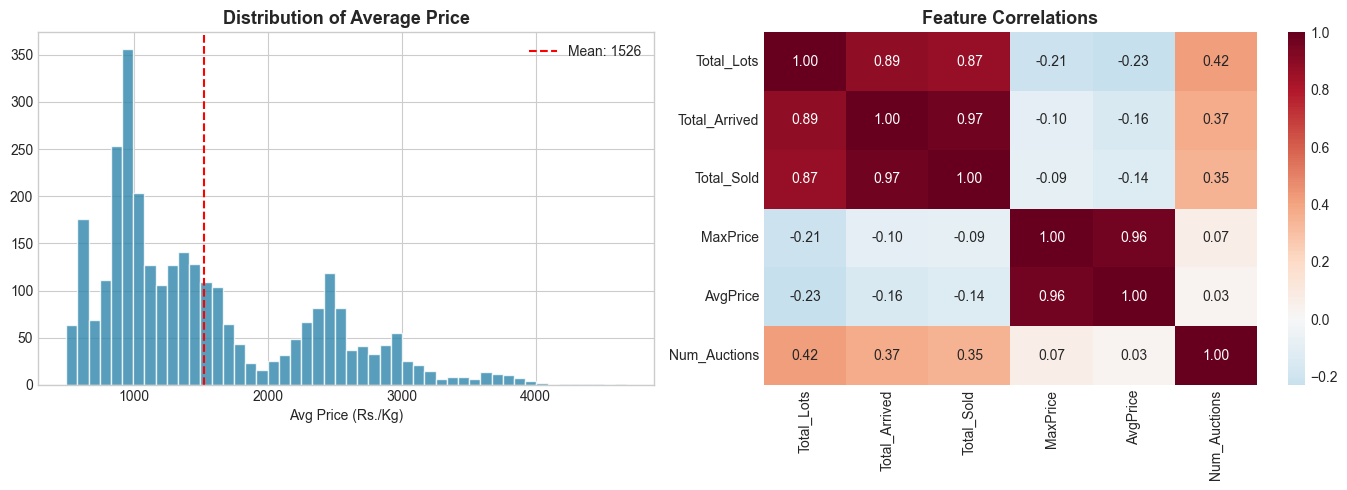

In [7]:
# Price distribution and correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(daily['AvgPrice'], bins=50, color='#2E86AB', edgecolor='white', alpha=0.8)
axes[0].set_title('Distribution of Average Price', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Avg Price (Rs./Kg)')
axes[0].axvline(daily['AvgPrice'].mean(), color='red', linestyle='--', label=f'Mean: {daily["AvgPrice"].mean():.0f}')
axes[0].legend()

corr_cols = ['Total_Lots', 'Total_Arrived', 'Total_Sold', 'MaxPrice', 'AvgPrice', 'Num_Auctions']
sns.heatmap(daily[corr_cols].corr(), annot=True, cmap='RdBu_r', center=0, ax=axes[1], fmt='.2f')
axes[1].set_title('Feature Correlations', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [8]:
# Create time-series features for forecasting
feat = daily[['Date', 'Total_Lots', 'Total_Arrived', 'Total_Sold', 'MaxPrice', 'AvgPrice', 'Num_Auctions']].copy()
feat = feat.sort_values('Date').reset_index(drop=True)

# --- Lag features ---
for lag in [1, 2, 3, 5, 7, 14, 21, 30]:
    feat[f'price_lag_{lag}'] = feat['AvgPrice'].shift(lag)
    
# --- Rolling window features ---
for window in [3, 7, 14, 30, 60]:
    feat[f'price_roll_mean_{window}'] = feat['AvgPrice'].shift(1).rolling(window).mean()
    feat[f'price_roll_std_{window}'] = feat['AvgPrice'].shift(1).rolling(window).std()
    feat[f'sold_roll_mean_{window}'] = feat['Total_Sold'].shift(1).rolling(window).mean()

# --- Price momentum ---
feat['price_change_1'] = feat['AvgPrice'].shift(1) - feat['AvgPrice'].shift(2)
feat['price_change_7'] = feat['AvgPrice'].shift(1) - feat['AvgPrice'].shift(8)
feat['price_pct_change_1'] = feat['AvgPrice'].shift(1).pct_change()
feat['price_pct_change_7'] = feat['AvgPrice'].shift(1).pct_change(7)

# --- Ratio features ---
feat['sold_to_arrived_ratio'] = (feat['Total_Sold'].shift(1) / feat['Total_Arrived'].shift(1).clip(lower=1))
feat['max_to_avg_ratio'] = (feat['MaxPrice'].shift(1) / feat['AvgPrice'].shift(1).clip(lower=1))

# --- Calendar features ---
feat['month'] = feat['Date'].dt.month
feat['day_of_week'] = feat['Date'].dt.dayofweek
feat['quarter'] = feat['Date'].dt.quarter
feat['week_of_year'] = feat['Date'].dt.isocalendar().week.astype(int)
feat['month_sin'] = np.sin(2 * np.pi * feat['month'] / 12)
feat['month_cos'] = np.cos(2 * np.pi * feat['month'] / 12)

# --- Days since last auction ---
feat['days_gap'] = feat['Date'].diff().dt.days

# Drop rows with NaN from lag/rolling calculations
feat = feat.dropna().reset_index(drop=True)
print(f'Features dataset: {feat.shape[0]} rows, {feat.shape[1]} columns')
feat.head()

Features dataset: 2968 rows, 43 columns


,Date,Total_Lots,Total_Arrived,Total_Sold,MaxPrice,AvgPrice,Num_Auctions,price_lag_1,price_lag_2,price_lag_3,...,price_pct_change_7,sold_to_arrived_ratio,max_to_avg_ratio,month,day_of_week,quarter,week_of_year,month_sin,month_cos,days_gap
0,2015-07-08,357,56733.0,55309.0,918.0,654.577261,2,639.919002,643.917837,651.133901,...,-0.075065,0.980386,1.564260,7,2,3,28,-0.5,-0.866025,1.0
1,2015-07-09,435,86016.0,86016.0,965.0,648.176854,2,654.577261,639.919002,643.917837,...,-0.049238,0.974900,1.402432,7,3,3,28,-0.5,-0.866025,1.0
2,2015-07-10,402,56129.0,53207.0,1019.0,636.261894,2,648.176854,654.577261,639.919002,...,-0.037916,1.000000,1.488791,7,4,3,28,-0.5,-0.866025,1.0
3,2015-07-11,499,78732.0,76481.0,976.0,628.059377,2,636.261894,648.176854,654.577261,...,-0.040354,0.947941,1.601542,7,5,3,28,-0.5,-0.866025,1.0
4,2015-07-13,350,51917.0,50151.0,994.0,638.474426,2,628.059377,636.261894,648.176854,...,-0.044606,0.971409,1.553993,7,0,3,29,-0.5,-0.866025,2.0


## 4. Model Training

We use a **temporal split** (no random shuffling) to respect the time-series nature of the data.

In [9]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Define features and target
exclude_cols = ['Date', 'AvgPrice', 'AvgPrice_WAM', 'AvgPrice_Simple']
feature_cols = [c for c in feat.columns if c not in exclude_cols]

# Remove current-day columns that would cause leakage
leakage_cols = ['Total_Lots', 'Total_Arrived', 'Total_Sold', 'MaxPrice', 'Num_Auctions']
feature_cols = [c for c in feature_cols if c not in leakage_cols]

X = feat[feature_cols]
y = feat['AvgPrice']
dates = feat['Date']

# Temporal split: last 20% for test
split_idx = int(len(feat) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_train, dates_test = dates.iloc[:split_idx], dates.iloc[split_idx:]

print(f'Train: {len(X_train)} samples ({dates_train.iloc[0].date()} to {dates_train.iloc[-1].date()})')
print(f'Test:  {len(X_test)} samples ({dates_test.iloc[0].date()} to {dates_test.iloc[-1].date()})')
print(f'Features: {len(feature_cols)}')
print(f'\nFeature list: {feature_cols}')

Train: 2374 samples (2015-07-08 to 2024-02-09)
Test:  594 samples (2024-02-10 to 2026-02-06)
Features: 36

Feature list: ['price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_5', 'price_lag_7', 'price_lag_14', 'price_lag_21', 'price_lag_30', 'price_roll_mean_3', 'price_roll_std_3', 'sold_roll_mean_3', 'price_roll_mean_7', 'price_roll_std_7', 'sold_roll_mean_7', 'price_roll_mean_14', 'price_roll_std_14', 'sold_roll_mean_14', 'price_roll_mean_30', 'price_roll_std_30', 'sold_roll_mean_30', 'price_roll_mean_60', 'price_roll_std_60', 'sold_roll_mean_60', 'price_change_1', 'price_change_7', 'price_pct_change_1', 'price_pct_change_7', 'sold_to_arrived_ratio', 'max_to_avg_ratio', 'month', 'day_of_week', 'quarter', 'week_of_year', 'month_sin', 'month_cos', 'days_gap']


In [10]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Train multiple models
models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=5, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, 
                                                    subsample=0.8, random_state=42)
}

results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'MAPE': f'{mape:.2f}%', 'R²': r2}
    print(f'{name:20s} | MAE: {mae:8.2f} | RMSE: {rmse:8.2f} | MAPE: {mape:5.2f}% | R²: {r2:.4f}')

results_df = pd.DataFrame(results).T
results_df

Ridge Regression     | MAE:    42.00 | RMSE:    54.91 | MAPE:  1.81% | R²: 0.9799


Random Forest        | MAE:    55.82 | RMSE:    69.11 | MAPE:  2.39% | R²: 0.9681


Gradient Boosting    | MAE:    65.41 | RMSE:    79.61 | MAPE:  2.77% | R²: 0.9577


,MAE,RMSE,MAPE,R²
Ridge Regression,42.001598,54.907092,1.81%,0.979868
Random Forest,55.821633,69.107899,2.39%,0.968108
Gradient Boosting,65.409976,79.609229,2.77%,0.95768


## 5. Model Evaluation & Visualization

Best model: Ridge Regression


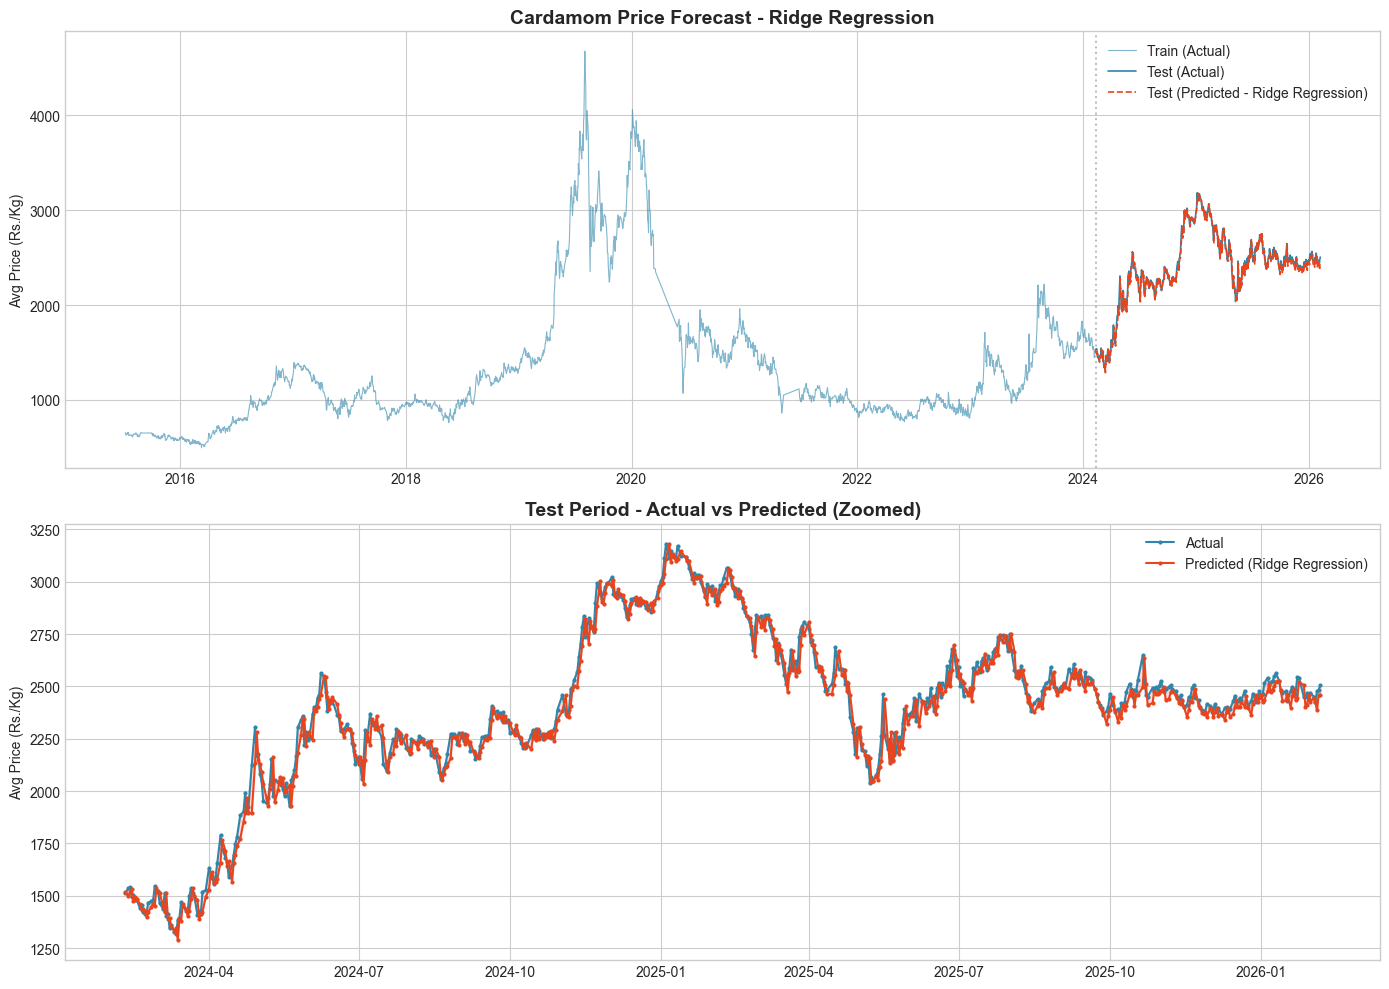

In [11]:
# Identify best model
best_name = min(results, key=lambda k: results[k]['MAE'])
best_pred = predictions[best_name]
print(f'Best model: {best_name}')

# Plot actual vs predicted
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Full timeline with test predictions
axes[0].plot(dates_train, y_train, label='Train (Actual)', color='#2E86AB', linewidth=0.8, alpha=0.6)
axes[0].plot(dates_test, y_test, label='Test (Actual)', color='#2E86AB', linewidth=1.2)
axes[0].plot(dates_test, best_pred, label=f'Test (Predicted - {best_name})', color='#E8451E', 
             linewidth=1.2, linestyle='--')
axes[0].set_title(f'Cardamom Price Forecast - {best_name}', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Avg Price (Rs./Kg)')
axes[0].legend()
axes[0].axvline(dates_test.iloc[0], color='gray', linestyle=':', alpha=0.5, label='Train/Test Split')

# Zoomed into test period
axes[1].plot(dates_test, y_test, label='Actual', color='#2E86AB', linewidth=1.5, marker='o', markersize=2)
axes[1].plot(dates_test, best_pred, label=f'Predicted ({best_name})', color='#E8451E', 
             linewidth=1.5, marker='o', markersize=2)
axes[1].fill_between(dates_test, y_test, best_pred, alpha=0.15, color='red')
axes[1].set_title('Test Period - Actual vs Predicted (Zoomed)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Avg Price (Rs./Kg)')
axes[1].legend()

plt.tight_layout()
plt.show()

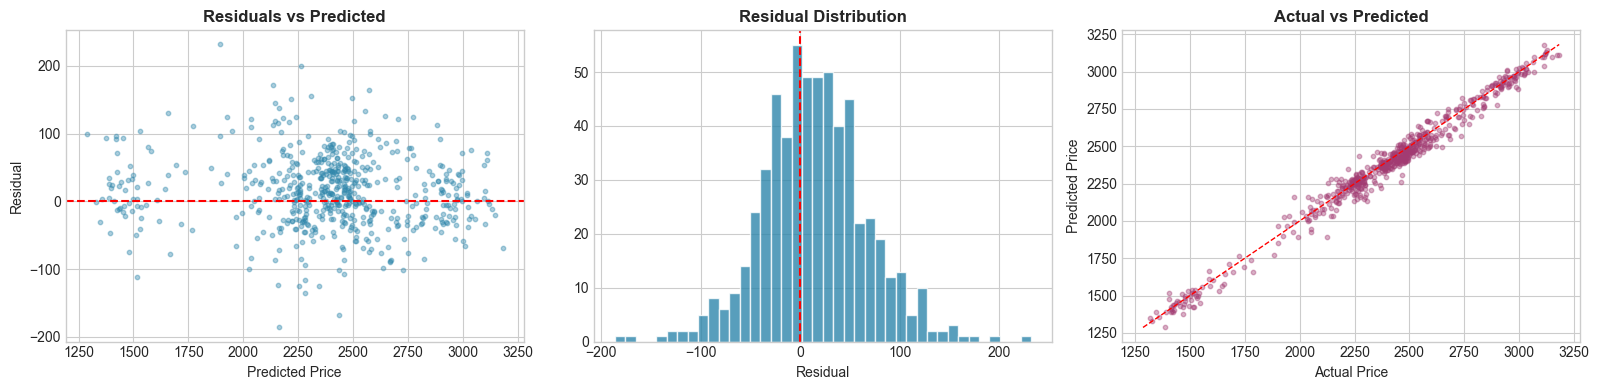

In [12]:
# Residual analysis
residuals = y_test.values - best_pred

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].scatter(best_pred, residuals, alpha=0.4, s=10, color='#2E86AB')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Predicted', fontweight='bold')
axes[0].set_xlabel('Predicted Price')
axes[0].set_ylabel('Residual')

axes[1].hist(residuals, bins=40, color='#2E86AB', edgecolor='white', alpha=0.8)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_title('Residual Distribution', fontweight='bold')
axes[1].set_xlabel('Residual')

axes[2].scatter(y_test, best_pred, alpha=0.4, s=10, color='#A23B72')
min_val = min(y_test.min(), best_pred.min())
max_val = max(y_test.max(), best_pred.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
axes[2].set_title('Actual vs Predicted', fontweight='bold')
axes[2].set_xlabel('Actual Price')
axes[2].set_ylabel('Predicted Price')

plt.tight_layout()
plt.show()

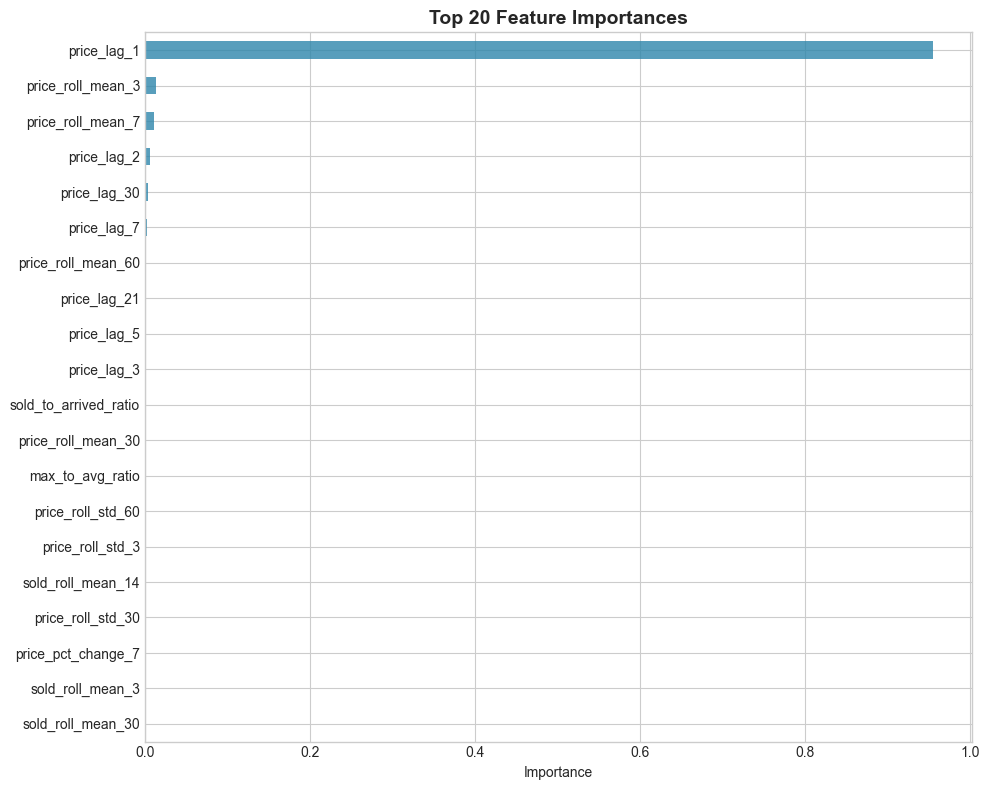

In [13]:
# Feature importance (from best tree-based model)
if best_name in ['Gradient Boosting', 'Random Forest']:
    best_model = models[best_name]
    importances = best_model.feature_importances_
else:
    # Fallback to Gradient Boosting importance
    best_model = models['Gradient Boosting']
    importances = best_model.feature_importances_

feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
feat_imp.tail(20).plot(kind='barh', ax=ax, color='#2E86AB', alpha=0.8)
ax.set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

## 6. Multi-Step Forecasting

Forecast N days ahead by iteratively predicting one step at a time and feeding predictions back as features.

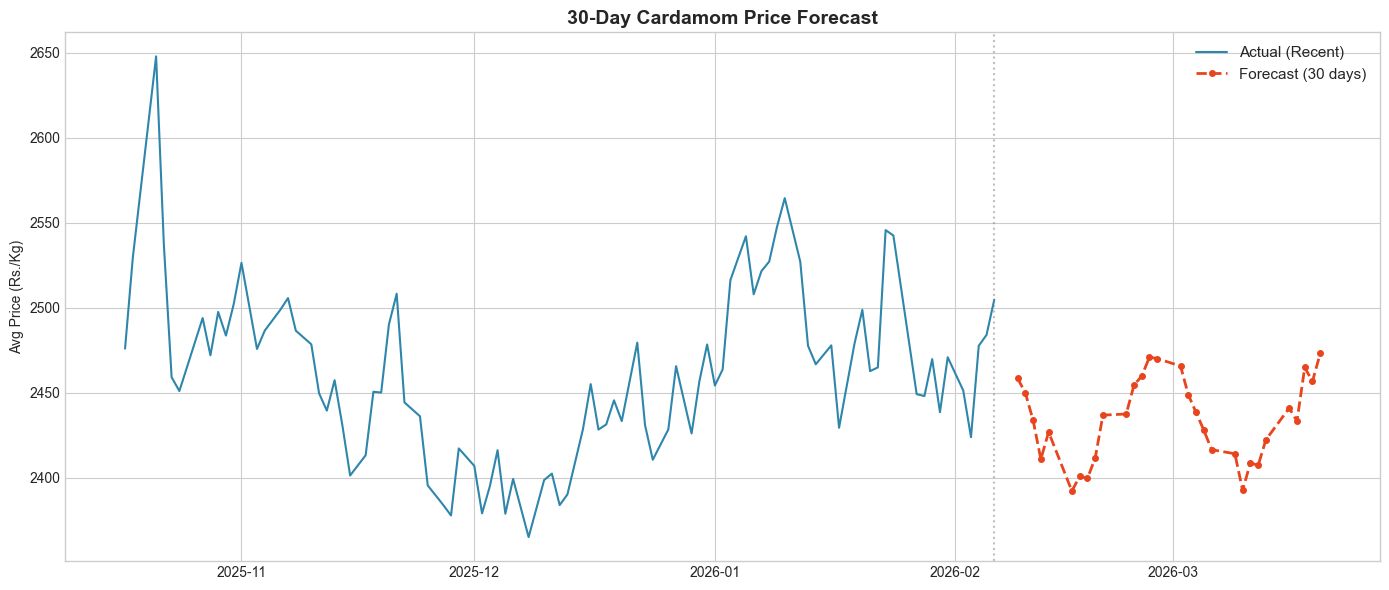


Forecast:
      Date  AvgPrice_Forecast
2026-02-09        2458.444478
2026-02-10        2449.793868
2026-02-11        2433.734274
2026-02-12        2410.779125
2026-02-13        2426.757279
2026-02-16        2392.032115
2026-02-17        2400.721965
2026-02-18        2399.459003
2026-02-19        2411.392989
2026-02-20        2436.712437
2026-02-23        2437.377392
2026-02-24        2454.312798
2026-02-25        2459.759997
2026-02-26        2470.852108
2026-02-27        2469.988421
2026-03-02        2465.627870
2026-03-03        2448.706579
2026-03-04        2438.293842
2026-03-05        2427.852583
2026-03-06        2416.386787
2026-03-09        2413.975850
2026-03-10        2392.459499
2026-03-11        2408.636918
2026-03-12        2407.107539
2026-03-13        2422.254677
2026-03-16        2440.857958
2026-03-17        2433.200096
2026-03-18        2464.753842
2026-03-19        2456.599783
2026-03-20        2473.009399


In [14]:
def forecast_n_steps(model, feat_df, feature_cols, n_steps=30):
    """
    Iterative multi-step forecast.
    Uses the last known data and rolls forward, using predictions as new lag values.
    """
    # Work with a copy of the full feature dataframe
    history = feat_df.copy()
    forecasts = []
    last_date = history['Date'].iloc[-1]
    
    for step in range(n_steps):
        # Get the last row's features
        last_row = history.iloc[-1:][feature_cols]
        pred = model.predict(last_row)[0]
        
        # Estimate next auction date (skip weekends roughly)
        next_date = last_date + timedelta(days=1)
        while next_date.weekday() >= 5:  # skip Sat/Sun
            next_date += timedelta(days=1)
        
        forecasts.append({'Date': next_date, 'AvgPrice_Forecast': pred})
        
        # Build a new row with updated lags
        new_row = history.iloc[-1:].copy()
        new_row['Date'] = next_date
        new_row['AvgPrice'] = pred
        
        # Update lag features
        price_history = list(history['AvgPrice'].values) + [pred]
        for lag in [1, 2, 3, 5, 7, 14, 21, 30]:
            col = f'price_lag_{lag}'
            if col in new_row.columns and lag <= len(price_history):
                new_row[col] = price_history[-lag-1] if lag < len(price_history) else np.nan
        
        # Update calendar features
        new_row['month'] = next_date.month
        new_row['day_of_week'] = next_date.weekday()
        new_row['quarter'] = (next_date.month - 1) // 3 + 1
        new_row['week_of_year'] = next_date.isocalendar()[1]
        new_row['month_sin'] = np.sin(2 * np.pi * next_date.month / 12)
        new_row['month_cos'] = np.cos(2 * np.pi * next_date.month / 12)
        new_row['days_gap'] = (next_date - last_date).days
        
        history = pd.concat([history, new_row], ignore_index=True)
        last_date = next_date
    
    return pd.DataFrame(forecasts)

# Forecast next 30 auction days using the best model
best_model = models[best_name]
forecast_df = forecast_n_steps(best_model, feat, feature_cols, n_steps=30)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Show last 90 days of actual data + forecast
recent = feat.tail(90)
ax.plot(recent['Date'], recent['AvgPrice'], label='Actual (Recent)', color='#2E86AB', linewidth=1.5)
ax.plot(forecast_df['Date'], forecast_df['AvgPrice_Forecast'], label='Forecast (30 days)', 
        color='#E8451E', linewidth=2, linestyle='--', marker='o', markersize=4)
ax.axvline(recent['Date'].iloc[-1], color='gray', linestyle=':', alpha=0.5)
ax.set_title('30-Day Cardamom Price Forecast', fontsize=14, fontweight='bold')
ax.set_ylabel('Avg Price (Rs./Kg)')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print('\nForecast:')
forecast_df['Date'] = forecast_df['Date'].dt.strftime('%Y-%m-%d')
print(forecast_df.to_string(index=False))

## 7. Summary

### Key Findings
- The model uses **lag prices, rolling statistics, momentum indicators, and calendar features** to predict the next auction's average cardamom price.
- **No data leakage**: all features use only past data (shifted by at least 1 period).
- The temporal train/test split ensures realistic evaluation.

### Possible Improvements
- Add external data: weather, rainfall in cardamom-growing regions (Idukki, Kerala)
- Add macroeconomic indicators: USD/INR exchange rate, inflation
- Try LSTM / Prophet for longer-horizon forecasting
- Hyperparameter tuning with time-series cross-validation
- Ensemble the models for more robust predictions